# Captcha Prediction using Tensorflow

### Import Libraries


In [1]:

import cv2
import pickle
import os.path
import time
import matplotlib.pyplot as plt
import numpy as np
import imutils

from imutils import paths
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
from tensorflow.python.framework import ops
from helpers import resize_to_fit

train_graph = tf.Graph()

/Users/pymacbit/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Store all file names and folder names
LETTER_IMAGES_FOLDER = "extracted_letter_images"
MODEL_LABELS_FILENAME = "model_labels.dat"
TEST_DATA_FOLDER = 'test_captcha'
CHECKPOINT = "./train_model.ckpt"

## Simplifying the problem

We can simplify the problem by spliting the captcha image into single letters. For that we have to train the neural network to recognize a single letter at a time. We can automate the process of splitting the images into separate letters.

In image processing, we often need to detect “blobs” of pixels that have the same color. The boundaries around those continuous pixels blobs are called contours. OpenCV has a built-in findContours() function that we can use to detect these continuous regions.

## preprocessed Train images and labels

In [3]:
# Initialize the data and labels
data = []
labels = []

# loop over the input images
for image_file in paths.list_images(LETTER_IMAGES_FOLDER):
    # Load the image and convert it to grayscale
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Resize the letter so it fits in a 20x20 pixel box
    image = resize_to_fit(image, 20, 20)

    # Add a third channel dimension to the image
    image = np.expand_dims(image, axis=2)

    # Grab the name of the letter based on the folder it was in
    label = image_file.split(os.path.sep)[-2]

    # Add the letter image and it's label to our training data
    data.append(image)
    labels.append(label)

In [4]:
# Scale the raw pixel intensities to the range [0, 1] (this improves training)

data = np.array(data, dtype="float") / 255.0
labels = np.array(np.expand_dims(labels, axis=1))

print(data.shape)
print(labels.shape)

(59143, 20, 20, 1)
(59143, 1)


In [5]:
# Convert the labels (letters) into one-hot encodings

lb = LabelBinarizer().fit(labels)
labels = lb.transform(labels)

print(labels.shape)

(59143, 18)


In [6]:
# Save the mapping from labels to one-hot encodings
# We'll need this later when we use the model to decode what it's predictions mean

with open(MODEL_LABELS_FILENAME, "wb") as f:
    pickle.dump(lb, f)

In [7]:
m = data.shape[0] # Number of training examples
n_H = data.shape[1] # Images' height
n_W = data.shape[2] # Images' width
n_C = data.shape[3] # number of channels
n_cls = labels.shape[1] # number of classes

# Create placeholders for the train data and label
with train_graph.as_default():
    X = tf.placeholder(tf.float32, [None, n_H, n_W, n_C], name = 'input')
    Y = tf.placeholder(tf.float32, [None, n_cls], name = 'output')

In [8]:
# Initialize the weights for the convolution layers
# shape = [filter_size, filter_size, num_input_channels, num_filters]

with train_graph.as_default():
    W1 = tf.get_variable("W1", [5, 5, 1, 20], initializer = tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2", [5, 5, 20, 50], initializer = tf.contrib.layers.xavier_initializer(seed=0))

## Create convolutional neural network


In [9]:
with train_graph.as_default():
    # Layer1 - Convolutional
    conv_layer1 = tf.nn.conv2d(X, W1, strides=[1, 1, 1, 1], padding='SAME', name = 'conv1')
    relu_layer1 = tf.nn.relu(conv_layer1, name = 'relu1')
    max_pool_layer1 = tf.nn.max_pool(relu_layer1, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding='SAME', name = 'pool1')

    # Layer2 - Convolutional
    conv_layer2 = tf.nn.conv2d(max_pool_layer1, W2, strides=[1, 1, 1, 1], padding='SAME', name = 'conv2')
    relu_layer2 = tf.nn.relu(conv_layer2, name = 'relu2')
    max_pool_layer2 = tf.nn.max_pool(relu_layer2, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding='SAME', name = 'pool2')

    # Layer3 - Fully_Connected (Don't forget to flatten the previous layer)
    flatten_layer3 = tf.contrib.layers.flatten(max_pool_layer2)
    fc_layer3 = tf.contrib.layers.fully_connected(flatten_layer3, 500, activation_fn=tf.nn.relu, scope = 'fc1')

    # Layer4 - Fully_Connected
    fc_layer4 = tf.contrib.layers.fully_connected(fc_layer3, n_cls, activation_fn=None, scope = 'fc2')
    print(fc_layer4)

Tensor("fc2/BiasAdd:0", shape=(?, 18), dtype=float32)


In [10]:
# Use cross entropy cost function

with train_graph.as_default():
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=fc_layer4, labels=Y)
    cost = tf.reduce_mean(cross_entropy)

    # Use adam optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

In [11]:
# Funcion: To pick random minibatches to train the model
def random_mini_batches(train, labels, batch_size, seed):
    # Always change the seed so that we randomize in different order
    np.random.seed(seed)
    # Make sure we shuffle both the train data and the label in the same order
    p = np.random.permutation(len(train))
    train = train[p]
    labels = labels[p]
    train_batches = []
    label_batches = []
    # Dividing the train data into minibatches
    for batch_i in range(0, len(train)//batch_size):
        start_i = batch_i * batch_size
        train_batch = train[start_i:start_i + batch_size]
        label_batch = labels[start_i:start_i + batch_size]
        train_batches.append(train_batch)
        label_batches.append(label_batch)
            
    return train_batches, label_batches 

## Training the model

Since the captcha images are split into letters, a simple convolutional network would be sufficient to achieve a better prediction. The architecture which is used here consists of two convlutional layers and two fully connected layers.

Epoch 0 completed : Time usage 78 seconds
	- Cost after epoch 0: 0.468789
Epoch 2 completed : Time usage 73 seconds
	- Cost after epoch 2: 0.004060
Epoch 4 completed : Time usage 73 seconds
	- Cost after epoch 4: 0.002958
Epoch 6 completed : Time usage 74 seconds
	- Cost after epoch 6: 0.002371
Epoch 8 completed : Time usage 72 seconds
	- Cost after epoch 8: 0.002195


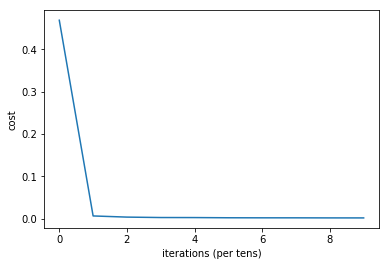

Train Accuracy: 0.9997971


In [12]:
ops.reset_default_graph()
tf.set_random_seed(1)
# Initialize all the hyperparameters
seed = 3
num_epochs=10
minibatch_size=64
costs = [] 

# Training the model
with tf.Session(graph=train_graph) as sess:
    # Initialize all variables
    sess.run(tf.global_variables_initializer())
    
    # If we want to continue training a previous session
    # loader = tf.train.import_meta_graph("./" + CHECKPOINT + '.meta')
    # loader.restore(sess, CHECKPOINT)
    
    # Loop over number of epochs
    for epoch in range(num_epochs):
        
        start_time = time.time()
        minibatch_cost = 0
        num_minibatches = int(m / minibatch_size)
        seed = seed + 1
        # Calling the random_mini_batches function to get the batches
        train_batches, label_batches = random_mini_batches(data, labels, minibatch_size, seed)
        
        # Now train the model for each of that batches and calculate the minibatch cost
        for batch_i in range(num_minibatches):
            
            # Choose the minibatches
            minibatch_X = train_batches[batch_i]
            minibatch_Y = label_batches[batch_i]
            
            _ , temp_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})
            
            minibatch_cost += temp_cost / num_minibatches
            
        # Print the cost every 2 epoch
        if epoch % 2 == 0:
            print("Epoch "+str(epoch)+" completed : Time usage "+str(int(time.time()-start_time))+" seconds")
            print("\t- Cost after epoch %i: %f" % (epoch, minibatch_cost))
            # Don't forget to save the model
            saver = tf.train.Saver() 
            saver.save(sess, CHECKPOINT)
        if epoch % 1 == 0:
            costs.append(minibatch_cost)
            
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.show()     
    
    # Calculate the correct predictions
    predict_op = tf.argmax(fc_layer4, 1)
    correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))

    # Calculate accuracy for the training data
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    train_accuracy = accuracy.eval({X: data, Y: labels})   
    print("Train Accuracy:", train_accuracy)

In [13]:
# Let's check the model on few tesrt data
test_data_files = list(paths.list_images(TEST_DATA_FOLDER))
print(test_data_files)

['test_captcha/KPENMT.png', 'test_captcha/UGEHLF.png', 'test_captcha/KCHPAE.png', 'test_captcha/CHHXCK.png', 'test_captcha/BBARPX.png', 'test_captcha/MLAAYH.png', 'test_captcha/AJEHCX.png', 'test_captcha/GXKMKX.png', 'test_captcha/TFPCNE.png', 'test_captcha/HGMPAU.png']


## Preprocessing the test images and making predicitons

Original Captcha - KPENMT
Predicted Captcha - KPENMT
---CORRECT---


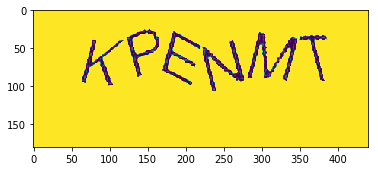

Original Captcha - UGEHLF
Predicted Captcha - UGEHLF
---CORRECT---


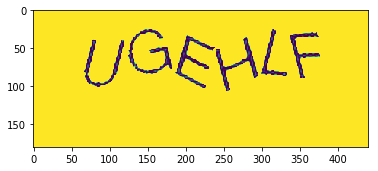

Original Captcha - KCHPAE
Predicted Captcha - KCHPAE
---CORRECT---


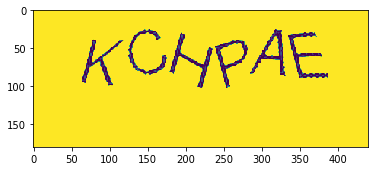

Original Captcha - CHHXCK
Predicted Captcha - CHHXCK
---CORRECT---


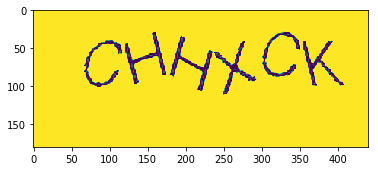

Original Captcha - BBARPX
Predicted Captcha - BBARPX
---CORRECT---


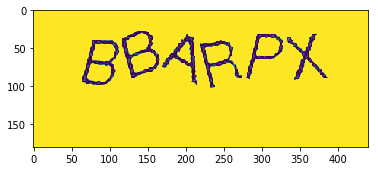

Original Captcha - MLAAYH
Predicted Captcha - MLAAYH
---CORRECT---


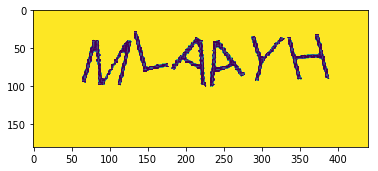

Original Captcha - AJEHCX
Predicted Captcha - AJEHCX
---CORRECT---


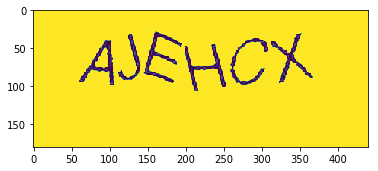

Original Captcha - TFPCNE
Predicted Captcha - TFPCNE
---CORRECT---


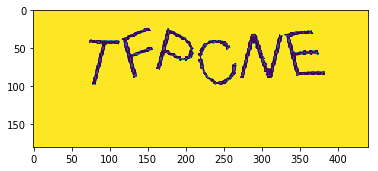

Original Captcha - HGMPAU
Predicted Captcha - HGMPAU
---CORRECT---


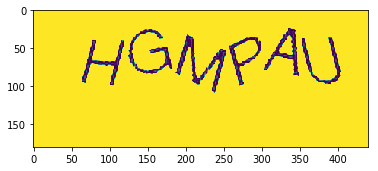

In [14]:
# Load up the model labels (so we can translate model predictions to actual letters)
with open(MODEL_LABELS_FILENAME, "rb") as f:
    lb = pickle.load(f)

# Ignoring the INFO from the tensorflow
tf.logging.set_verbosity(tf.logging.ERROR)

loaded_graph = tf.Graph()    

# loop over the image paths
for image_file in test_data_files:
    
    # Name of the image file is the ground truth for our predictions.
    filename = os.path.basename(image_file)
    captcha_correct_text = os.path.splitext(filename)[0]
    
    # Load the image and convert it to grayscale
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Add some extra padding around the image
    image = cv2.copyMakeBorder(image, 20, 20, 20, 20, cv2.BORDER_REPLICATE)

    # threshold the image (convert it to pure black and white)
    thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    # find the contours (continuous blobs of pixels) the image
    contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Hack for compatibility with different OpenCV versions
    contours = contours[0] if imutils.is_cv2() else contours[1]

    letter_image_regions = []

    # Now we can loop through each of the four contours and extract the letter
    # inside of each one
    for contour in contours:
        # Get the rectangle that contains the contour
        (x, y, w, h) = cv2.boundingRect(contour)

        # Compare the width and height of the contour to detect letters that
        # are conjoined into one chunk
        if w / h > 1.25:
            # This contour is too wide to be a single letter!
            # Split it in half into two letter regions!
            half_width = int(w / 2)
            letter_image_regions.append((x, y, half_width, h))
            letter_image_regions.append((x + half_width, y, half_width, h))
        else:
            # This is a normal letter by itself
            letter_image_regions.append((x, y, w, h))

    # If we found more or less than 6 letters in the captcha, our letter extraction
    # didn't work correcly. Skip the image.
    if len(letter_image_regions) != 6:
        continue

    # Sort the detected letter images based on the x coordinate to make sure
    # we are processing them from left-to-right so we match the right image
    # with the right letter
    letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])

    # Create an output image and a list to hold our predicted letters
    output = cv2.merge([image] * 3)
    predictions = []

    # loop over the letters
    for n,letter_bounding_box in enumerate(letter_image_regions):
        # Grab the coordinates of the letter in the image
        x, y, w, h = letter_bounding_box

        # Extract the letter from the original image with a 2-pixel margin around the edge
        letter_image = image[y - 2:y + h + 2, x - 2:x + w + 2]

        # Re-size the letter image to 20x20 pixels to match training data
        letter_image = resize_to_fit(letter_image, 20, 20)

        # Turn the single image into a 4d list of images so that the Tensorflow can handle
        letter_image = np.expand_dims(letter_image, axis=2)
        letter_image = np.expand_dims(letter_image, axis=0)
        
        # Load the Tensorflow session
        with tf.Session(graph=loaded_graph) as sess:
            
            # Load the saved model
            loader = tf.train.import_meta_graph(CHECKPOINT + '.meta')
            loader.restore(sess, CHECKPOINT)
            
            # Load the required parameters from the graph
            final_layer = loaded_graph.get_tensor_by_name('fc2/BiasAdd:0')
            input_layer = loaded_graph.get_tensor_by_name('input:0')
            
            # Making the predicitons
            predict = tf.argmax(final_layer, 1)
            output = predict.eval({input_layer: letter_image})
            
            # Append the correct letters to a list
            predictions.append(lb.classes_[output[0]])
    
    # Let's print our results and determine if it's correct or not
    print("Original Captcha - " + captcha_correct_text)
    print("Predicted Captcha - " + ''.join(predictions))
    if captcha_correct_text == ''.join(predictions):
        print("---CORRECT---")
    else:
        print("---WRONG---")
    
    # Plotting the captcha image as well
    plt.imshow(image)
    plt.show()